In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from class_pig import pigClass  

from pathlib import Path
import pickle

"""
CUIDADO!!
"""
import warnings
warnings.filterwarnings("ignore")

In [2]:
from fitterClass import funcFitter
from utils import exponential_cicle, find_best_b, plot_exponentials
from collections import namedtuple

In [3]:
def sigmoid(x, a, b, c, d):
    return a + b/(1 + np.exp(-(x-c)/d))

def exponential(x, a, b, c, d):
    return a - b*np.exp(-(x-c)/d)

def exponential_cicle_fixed_b(best_b, x, a, c):
    return -a*np.exp(-best_b*x)+c

estimators = ["lm", "trf", "dogbox"]
funcs = [sigmoid, exponential]

In [4]:
dataframes_lst = []
aux_test = {}
for file_name in Path('porquinhos').rglob('*.pickle'):
    
    if file_name.name == "porquinho_mra26.pickle": 
        print(file_name.name)
        
        with open(file_name, "rb") as file:

            porquinho = pickle.load(file)
            for manobra in porquinho: #Para cada manobra 

                if manobra == "D": # Posso fazer 3,4,5 passos
                    n_steps = 5
                elif manobra == "C": # Posso fazer 3,4 passos
                    n_steps = 4
                elif manobra == "B": # Posso fazer 3 passos
                    n_steps = 3

                # Formato os dados de entrada
                format_data = []

                for pi, pe, wi, we in zip(porquinho[manobra]["p_i"], porquinho[manobra]["p_e"],
                                          porquinho[manobra]["w_i"], porquinho[manobra]["w_e"]):

                    format_data.extend([pi,wi,pe,we])

                format_data = np.array(format_data).reshape(-1,2)

                ##########################################################

                for n_point in range(3,n_steps+1):
                    if manobra == "D" and porquinho.name == "mra26":
                        aux_test[n_point] = format_data.copy()
                    fitter = funcFitter(porquinho.name, manobra, format_data, format_data[0::2, :], n_point = n_point, estimators = estimators)
                    dataframes_lst.append(fitter.fit(funcs=funcs, interpolate=True, n_interp_point=20, interp_method="linear"))

porquinho_mra26.pickle


In [5]:
df = pd.concat(dataframes_lst,ignore_index=True)

In [6]:
df_test = df.query("manobra == 'D'")\
            .sort_values(by = "error")\
            .reset_index(drop=True)\
            .loc[:4]\
            .copy()

In [7]:
df_test[["best_b", "guess_zero"]] = df_test.apply(find_best_b, axis=1, result_type="expand")

In [8]:
df_test.iloc[0]

subject                                                        mra26
manobra                                                            D
n_point                                                            5
function                        <function sigmoid at 0x7f9dc994d9d0>
function_name                                                sigmoid
estimator                                                     dogbox
error                                                       0.227276
param              [-296.6860380701256, 1708.233716763266, 28.173...
interp_point                                                       5
interp_pressure    [10.178125381469727, 15.249219179153442, 20.32...
interp_volume      [-197.8517303466797, -93.77818494931996, 93.38...
raw_data           [[10.178125381469727, -197.8517303466797], [20...
best_b                                                         0.057
guess_zero                  [10.05812538146973, -199.43215421710016]
Name: 0, dtype: object

Best b: 0.05700000000000001
Best zero: [  10.05812538 -199.43215422]


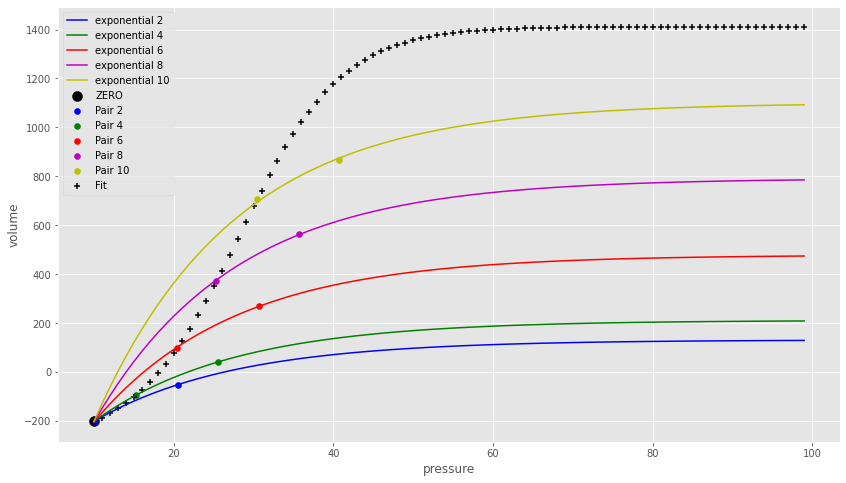

Best b: 0.05700000000000001
Best zero: [  10.05812538 -199.43215422]


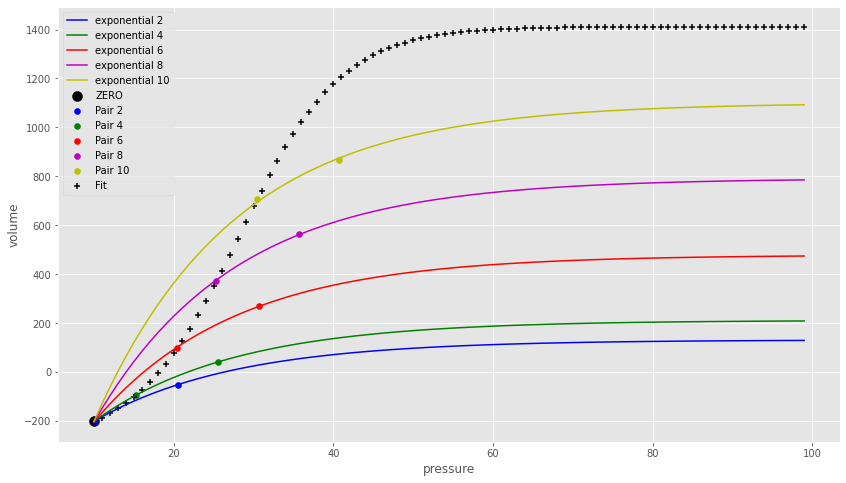

Best b: 0.06000000000000001
Best zero: [   9.85812538 -199.90247484]


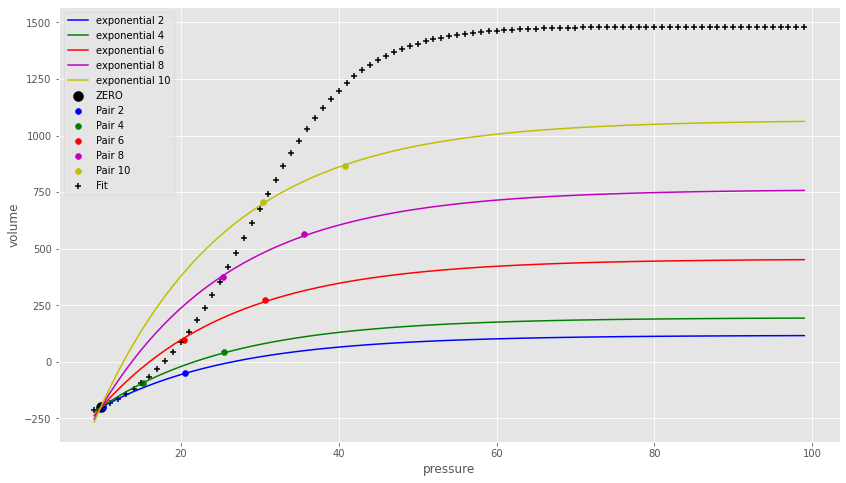

Best b: 0.06000000000000001
Best zero: [   9.85812538 -199.90247521]


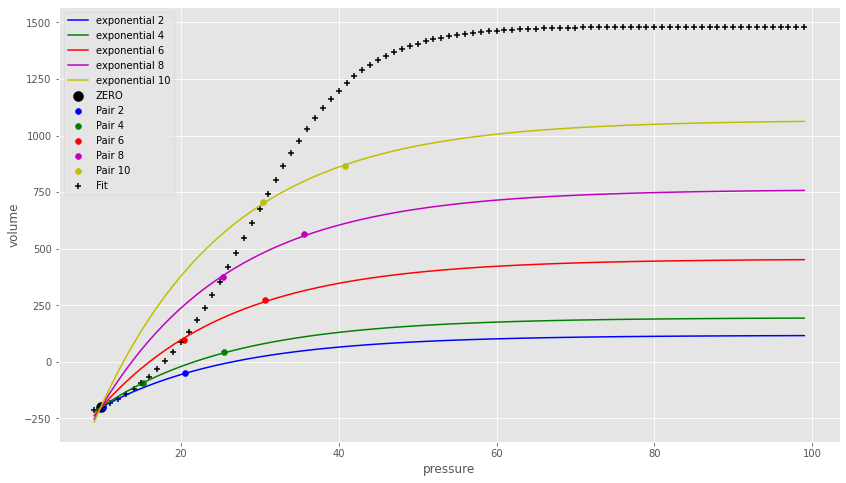

Best b: 0.06000000000000001
Best zero: [   9.85812538 -199.90247533]


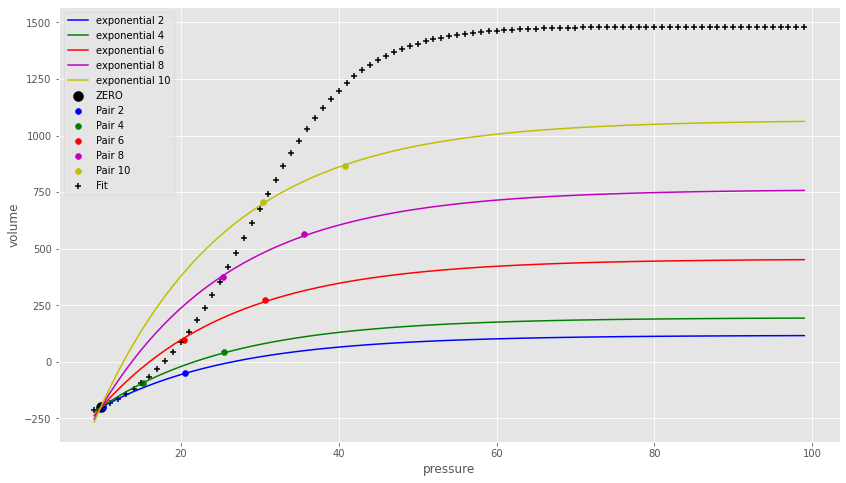

In [9]:
df_test["exponentials"] = df_test.apply(plot_exponentials, args = [exponential_cicle_fixed_b], axis=1)

In [10]:
def getMeanPoint(array, idx):
    pass
    
def test_frc_volume(ser):
    
    select_exp = 2
    
    [select_exp]
    guess_zero    = ser["guess_zero"]
    
    pressures = exponential.x
    exponential_volumes = exponential.y
    
    sigmoid_volumes   = ser["function"](pressures, *ser["param"])
    idx = np.argwhere(np.diff(np.sign(sigmoid_volumes - exponential_volumes))).flatten()
    
    plt.figure(figsize=(20,14))
    _=plt.plot(pressures, sigmoid_volumes, c = "r")
    _=plt.plot(pressures, exponential_volumes, c = "b")
    plt.scatter(pressures[idx], exponential_volumes[idx], c='k', s = 40)
    plt.scatter(raw_point[0], raw_point[1], c='g', s = 20)
    return idx

In [11]:
def get_rec_volume(raw_data, isPlot):
    pass

def get_arp_volume(exponentials, sigmoid_volumes, isPlot):
    arp_lst = []
    max_vol = sigmoid_volumes[-1]
    for exp in exponentials:
        arp_lst.append(max_vol - exp.y[-1])
        
        if isPlot:
            plt.vlines(x=exp.x[-1], ymin=exp.y[-1], ymax=max_vol, lw = 1, colors='k', linestyles = "solid")
            plt.hlines(y=exp.y[-1], xmin=0, xmax=exp.x[-1], lw = 1, colors='k', linestyles = "dashed", alpha = 0.4) 
            plt.hlines(y=max_vol, xmin=0, xmax=exp.x[-1], lw = 1, colors='k', linestyles = "dashed", alpha = 0.4) 
            plt.annotate(r"ARP", xy = (exp.x[-1], max_vol), weight="bold")
            
    return arp_lst

def get_irv_volume(exponentials, snd_raw_data, isPlot):
    
    irv_lst = []
    for exp, snd_raw in zip(exponentials, snd_raw_data):
        
        irv_lst.append(exp.y[-1] - snd_raw[1])
        
        if isPlot:
            plt.vlines(x=exp.x[-1], ymin=snd_raw[1], ymax=exp.y[-1], lw = 1, colors='k', linestyles = "solid")
            plt.hlines(y=snd_raw[1], xmin=snd_raw[0], xmax=exp.x[-1], lw = 1, colors='k', linestyles = "dashed") 
            plt.annotate(r"IRV", xy = (exp.x[-1], exp.y[-1]), weight="bold")
            
    return irv_lst

def get_vt_volume(raw_data, isPlot):
    
    vt_lst = []
    for fst_raw, snd_raw in zip(raw_data[::2], raw_data[1::2]):
        
        x1, y1 = fst_raw
        x2, y2 = snd_raw
        vt_lst.append(y2 - y1)
    
        if isPlot:
            plt.hlines(y=y1, xmin=x1, xmax=x2, lw = 1, colors='k', linestyles = "dashed")
            plt.vlines(x=x2, ymin=y1, ymax=y2, lw = 1, colors='k', linestyles = "solid")
            plt.annotate(r"VT", xy = (x2, y2), weight="bold")
        
    return vt_lst

def get_frc_volume(guess_zero_y, fst_raw_data, isPlot):    
    
    frc_lst = []
    
    for raw_x, raw_y in fst_raw_data:
        
        if isPlot:
            plt.vlines(x=raw_x, ymin=guess_zero_y, ymax=raw_y, lw = 1, colors='k', linestyles = "solid")
            plt.annotate(r"FRC", xy = (raw_x, raw_y), weight="bold")
            
        frc_lst.append(raw_y - guess_zero_y)
    
    return frc_lst

def get_volumes(ser, isPlot):
    
    raw_data        = ser["raw_data"]
    fst_raw_data    = ser["raw_data"][::2]
    snd_raw_data    = ser["raw_data"][1::2]
    guess_zero      = ser["guess_zero"]
    exponentials    = ser["exponentials"]
    
    colors = ["r","m","y","b","g","c"]
    plt.figure(figsize = (20,8))
    
    init_raw_x = raw_data[0][0]
    init_raw_y = raw_data[0][1]
    
    if np.array(list(isPlot.values())).any(): 
        sigmoid_volumes   = ser["function"](exponentials[-1].x, *ser["param"])
        plt.scatter(exponentials[-1].x, sigmoid_volumes, c = "c", marker = "+", label = "Sigmoid")
        for idx, (c, exp, fst_raw, snd_raw) in enumerate(zip(colors, exponentials, raw_data[::2], raw_data[1::2])):
            plt.scatter(fst_raw[0], fst_raw[1], c = c, marker = ".", s = 60)
            plt.scatter(snd_raw[0], snd_raw[1], c = c, marker = ".", s = 60)
            plt.plot(exp.x, exp.y,  c=c, lw=2)
            
    try:
        frc_lst = get_frc_volume(guess_zero[1], fst_raw_data, isPlot["FRC"])
    except:
        frc_lst = []
        
    try:
        vt_lst = get_vt_volume(raw_data, isPlot["VT"])
    except:
        vt_lst = []
    
    #try:
    irv_lst = get_irv_volume(exponentials, snd_raw_data, isPlot["IRV"])
    #except:
    #    irv_lst = []
        
    try:
        arp_lst = get_arp_volume(exponentials, sigmoid_volumes, isPlot["ARP"])
    except:
        arp_lst = []
        
    plt.legend()
    plt.show()
    
    return frc_lst, vt_lst, irv_lst, arp_lst


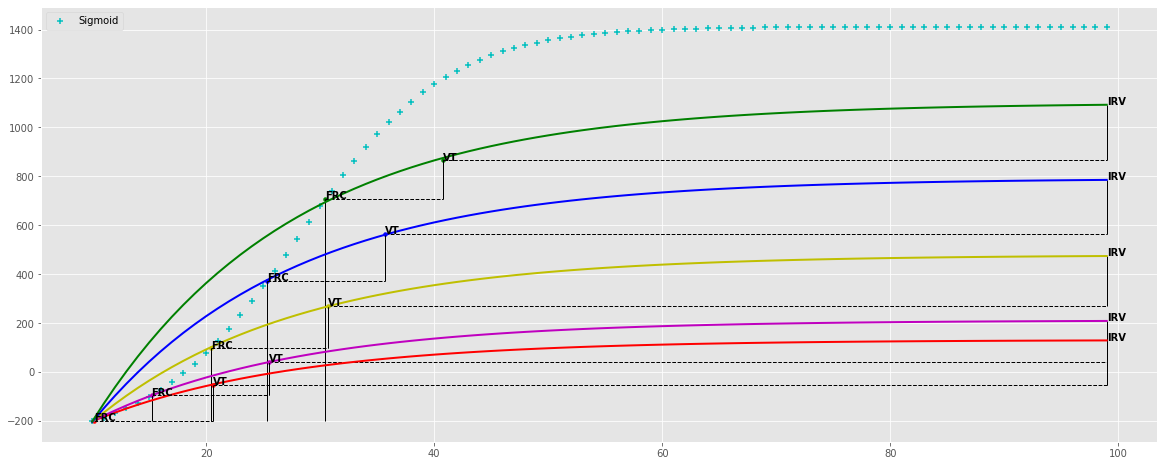

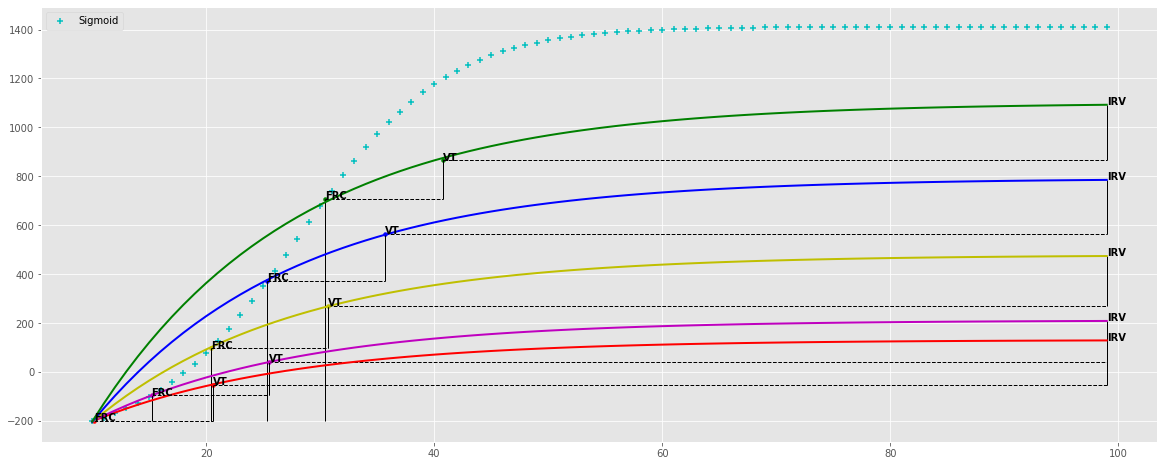

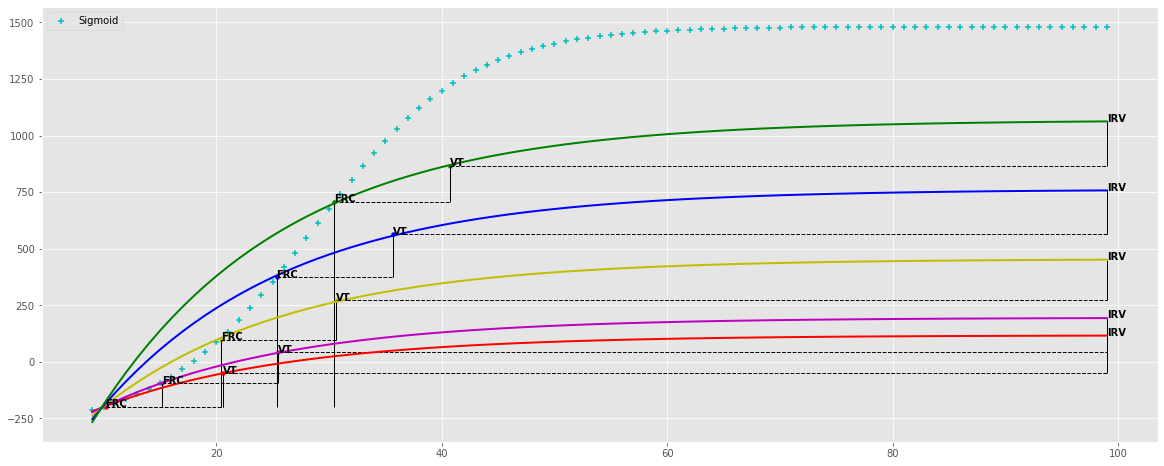

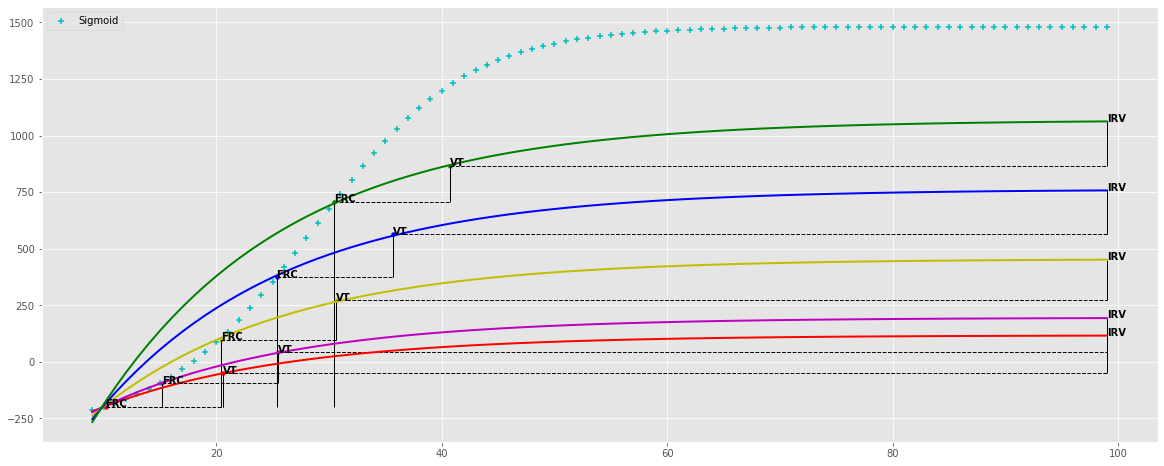

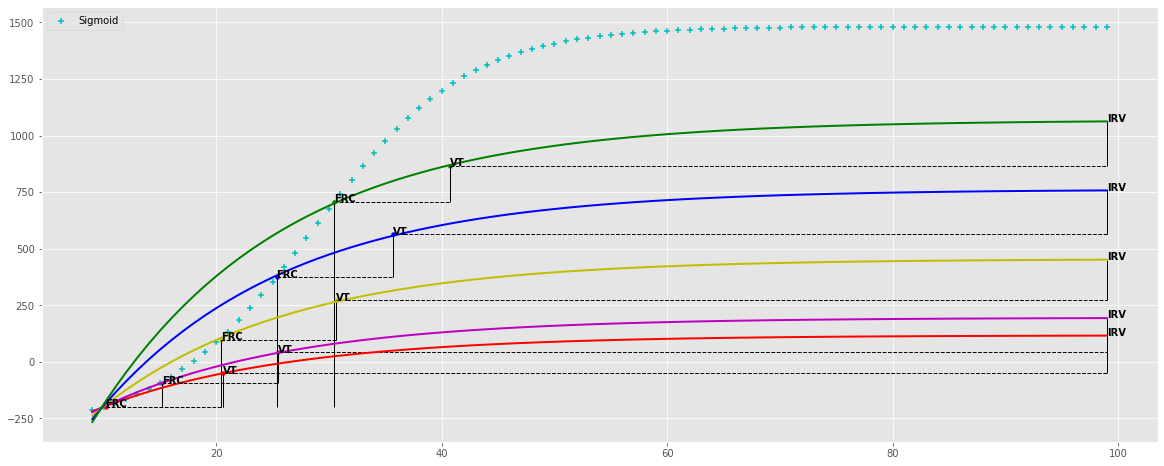

In [12]:
isPlot = {"FRC":True, "VT":True, "IRV": True, "ARP": False}
df_test[["FRC_V", "VT_V", "IRV_V", "ARP_V"]] = df_test.apply(get_volumes, args = [isPlot], axis =1, result_type = "expand")

In [13]:
df_test.filter(regex = "_V")

,FRC_V,VT_V,IRV_V,ARP_V
0,"[1.580423870420475, 104.2987161067486, 296.567...","[147.45708847045898, 136.6566925048828, 174.72...","[180.17633705381905, 167.83034047501164, 202.7...","[1281.7369190914098, 1202.1650193994653, 936.9..."
1,"[1.580423870934112, 104.29871610726224, 296.56...","[147.45708847045898, 136.6566925048828, 174.72...","[180.17633705414215, 167.83034046893812, 202.7...","[1281.7369191090456, 1202.1650194234976, 936.9..."
2,"[2.0507444978427998, 104.76903673417092, 297.0...","[147.45708847045898, 136.6566925048828, 174.72...","[166.53858661320152, 151.99347678704697, 180.0...","[1365.335403364783, 1287.9626169201854, 1029.6..."
3,"[2.0507448618501485, 104.76903709817827, 297.0...","[147.45708847045898, 136.6566925048828, 174.72...","[166.53858682479492, 151.99347709196667, 180.0...","[1365.335423291576, 1287.9626367536523, 1029.6..."
4,"[2.050744986362872, 104.769037222691, 297.0377...","[147.45708847045898, 136.6566925048828, 174.72...","[166.53858691277998, 151.99347723352366, 180.0...","[1365.335427014874, 1287.9626404233784, 1029.6..."
